In [2]:
import torch
from tqdm import tqdm
from time import time
from torch.optim import Adam
from models.SceneNet import SceneNet
from torch.utils.data import DataLoader
from losses import Loss_SceneFlow_SelfSup, Loss_SceneFlow_SelfSup_NoOcc
from augmentations import Augmentation_Resize_Only, Augmentation_SceneFlow
from models.model_monosceneflow import MonoSceneFlow
from models.encoders import ResNetEncoder, PWCEncoder
from datasets.kitti_raw_monosf import KITTI_Raw_KittiSplit_Train

class Args:
    cuda = True
    model_name = 'monoflow'
    use_bn = False
    use_pwc_encoder = False
    use_resnet_encoder = True
    use_refinement_layers = False
    evaluation = False
    finetuning = False
    momentum = 0.9
    beta = 0.999
    weight_decay=0.0
    use_mask = True
    
args = Args()
model = SceneNet(args)

# augmentations = Augmentation_Resize_Only(args).cuda()
# optimizer = Adam(model.parameters(), lr=2e-6, betas=[args.momentum, args.beta], weight_decay=args.weight_decay)

# data_root = '/external/datasets/kitti_data_jpg/'
# train_dataset = KITTI_Raw_KittiSplit_Train(args, root=data_root, num_examples=1, flip_augmentations=False, preprocessing_crop=False)
# train_loader = DataLoader(train_dataset)
# loss = Loss_SceneFlow_SelfSup(args)

In [4]:
state_dict = torch.load('./pretrained/posenet.pth.tar')['state_dict']
_, _ = model.pose_decoder.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for PoseExpNet:
	Missing key(s) in state_dict: "upconv5.0.weight", "upconv5.0.bias", "upconv4.0.weight", "upconv4.0.bias", "upconv3.0.weight", "upconv3.0.bias", "upconv2.0.weight", "upconv2.0.bias", "upconv1.0.weight", "upconv1.0.bias", "predict_mask5.weight", "predict_mask5.bias", "predict_mask4.weight", "predict_mask4.bias", "predict_mask3.weight", "predict_mask3.bias", "predict_mask2.weight", "predict_mask2.bias", "predict_mask1.weight", "predict_mask1.bias". 
	Unexpected key(s) in state_dict: "conv8.0.weight", "conv8.0.bias". 
	size mismatch for conv1.0.weight: copying a param with shape torch.Size([16, 15, 7, 7]) from checkpoint, the shape in current model is torch.Size([16, 6, 7, 7]).
	size mismatch for pose_pred.weight: copying a param with shape torch.Size([24, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 256, 1, 1]).
	size mismatch for pose_pred.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([6]).

In [3]:
for data in train_loader:
    with torch.no_grad():
        data_dict = augmentations(data)

torch.Size([1, 256, 832])
tensor(1.2960, device='cuda:0')
tensor(1.1612, device='cuda:0')
torch.Size([1, 256, 832])


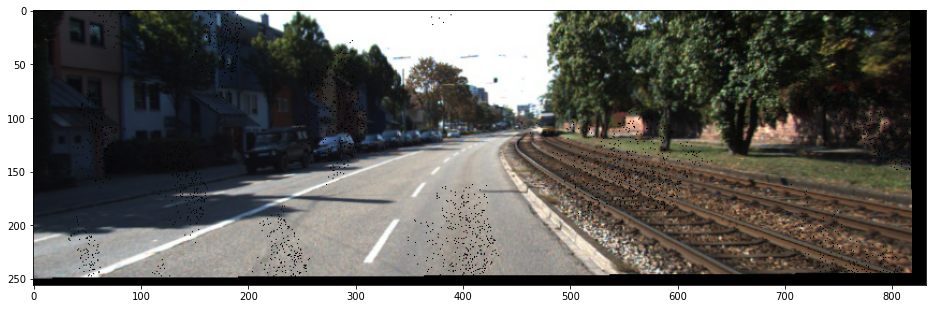

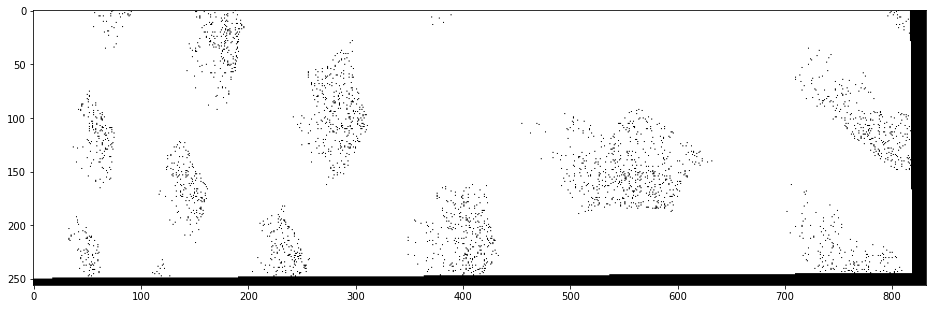

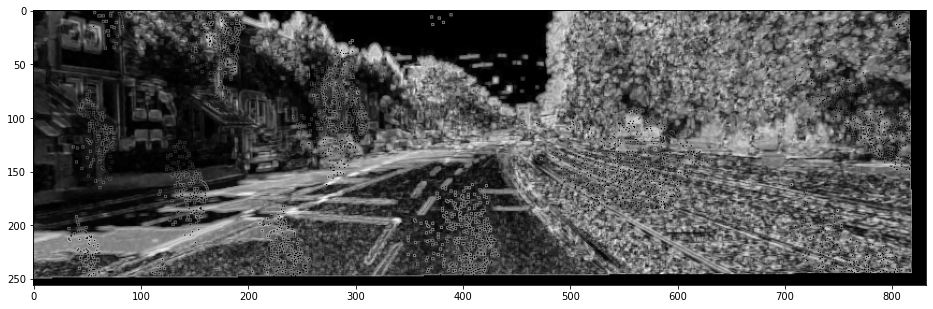

In [90]:
import matplotlib.pyplot as plt
from utils.sceneflow_util import pixel2pts_ms_depth, pts2pixel_pose_ms, reconstructImg
from losses import _SSIM, _elementwise_l1

img_l1 = data_dict['input_l1_aug']
img_r1 = data_dict['input_r1_aug']
img_l2 = data_dict['input_l2_aug']
img_r2 = data_dict['input_r2_aug']
k_l1 = data_dict['input_k_l1_aug']
k_l2 = data_dict['input_k_l2_aug'].cuda()
k_r1 = data_dict['input_k_r1_aug']
aug_size = data_dict['aug_size'].cuda()

k_aug = k_l2.cuda()
img1_aug = img_l1
img2_aug = img_l2.cuda()

disp = torch.ones((1, 1, 256, 832)).cuda()
b, _, h, w = disp.shape
disp = disp * w

pose = torch.rand((b, 6)).cuda() * 0.01

local_scale = torch.zeros_like(aug_size)
local_scale[:, 0] = h
local_scale[:, 1] = w

pts, intrinsics_scaled, depth = pixel2pts_ms_depth(k_aug, disp, local_scale/aug_size)
pts_tform, norm_coord = pts2pixel_pose_ms(intrinsics_scaled, pts, pose, [h, w])
img_warp = reconstructImg(norm_coord, img1_aug.cuda())

valid_pixels = (img_warp.sum(dim=1) != 0).float()
print(valid_pixels.shape)

diff = (_elementwise_l1(img2_aug, img_warp) * (1.0 - 0.85) + _SSIM(img2_aug, img_warp) * 0.85).mean(dim=1, keepdim=True)
print(diff.mean() * 4)
diff *= valid_pixels
print(diff.mean() * 4)

img_warp = img_warp.cpu().squeeze().permute(1, 2, 0)
print(valid_pixels.shape)
valid_pixels = valid_pixels.cpu().squeeze()
diff = diff.cpu().squeeze()

plt.figure(figsize=(16, 16));
plt.imshow(img_warp);

plt.figure(figsize=(16, 16));
plt.imshow(valid_pixels, cmap='gray');

plt.figure(figsize=(16, 16));
plt.imshow(diff, cmap='gray');

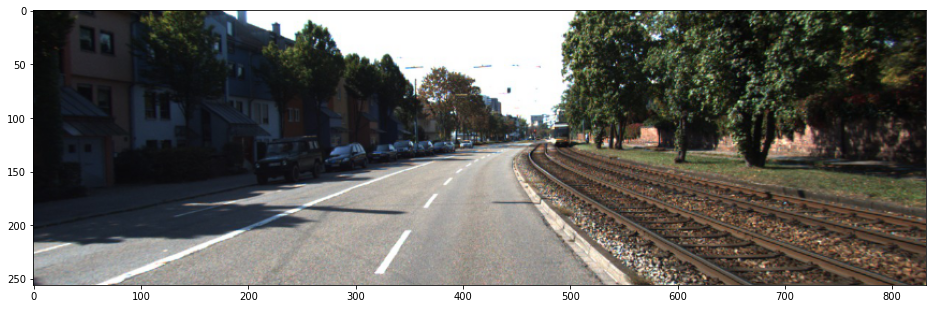

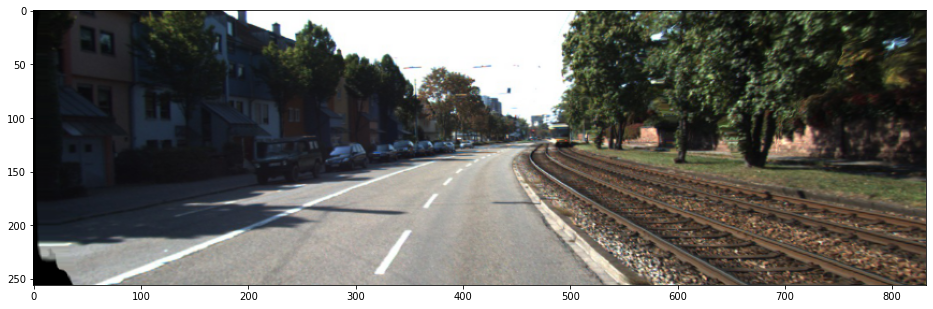

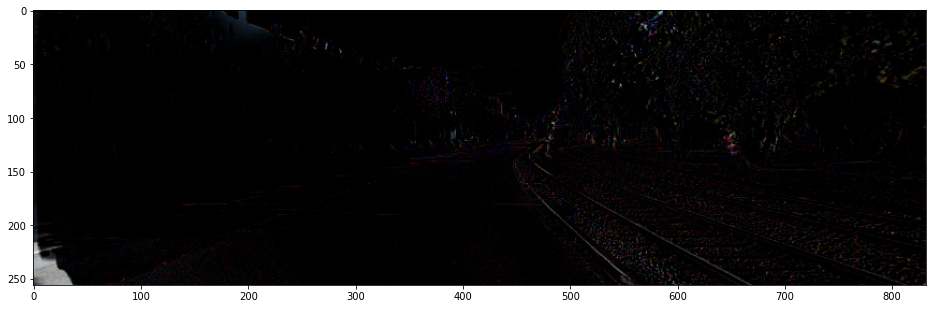

In [20]:
from losses import _generate_image_left
import matplotlib.pyplot as plt
from utils.sceneflow_util import pts2pixel_ms, pixel2pts_ms


img_l1 = data['input_l1_aug'].cpu().detach()
img_r1 = data['input_r1_aug'].cpu().detach()
img_l2 = data['input_l2_aug'].cpu().detach()
k_l1 = data['input_k_l1_aug'].cpu().detach()

disp_l1 = output_dict['disp_l1'][0].cpu().detach()
img_r1_warp = _generate_image_left(img=img_r1, disp=disp_l1)

plt.figure(figsize=(16, 16))
plt.imshow(img_l1.squeeze().permute(1, 2, 0).numpy())
plt.show()
plt.figure(figsize=(16, 16))
plt.imshow(img_r1_warp.squeeze().permute(1, 2, 0).numpy())
plt.show()
plt.figure(figsize=(16, 16))
plt.imshow(img_l1.squeeze().permute(1, 2, 0).numpy() - img_r1_warp.squeeze().permute(1, 2, 0).numpy())
plt.show()